In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [1]:
# load data
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [243]:
# understanding bigrams
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

e m
m m
m a


In [12]:
# Counting bi-grams
b = {}
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [44]:
# string to integer and integer to string list
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()} # could use enum(chars) but <.> will be missed

In [47]:
# count matrix
N = torch.zeros((27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

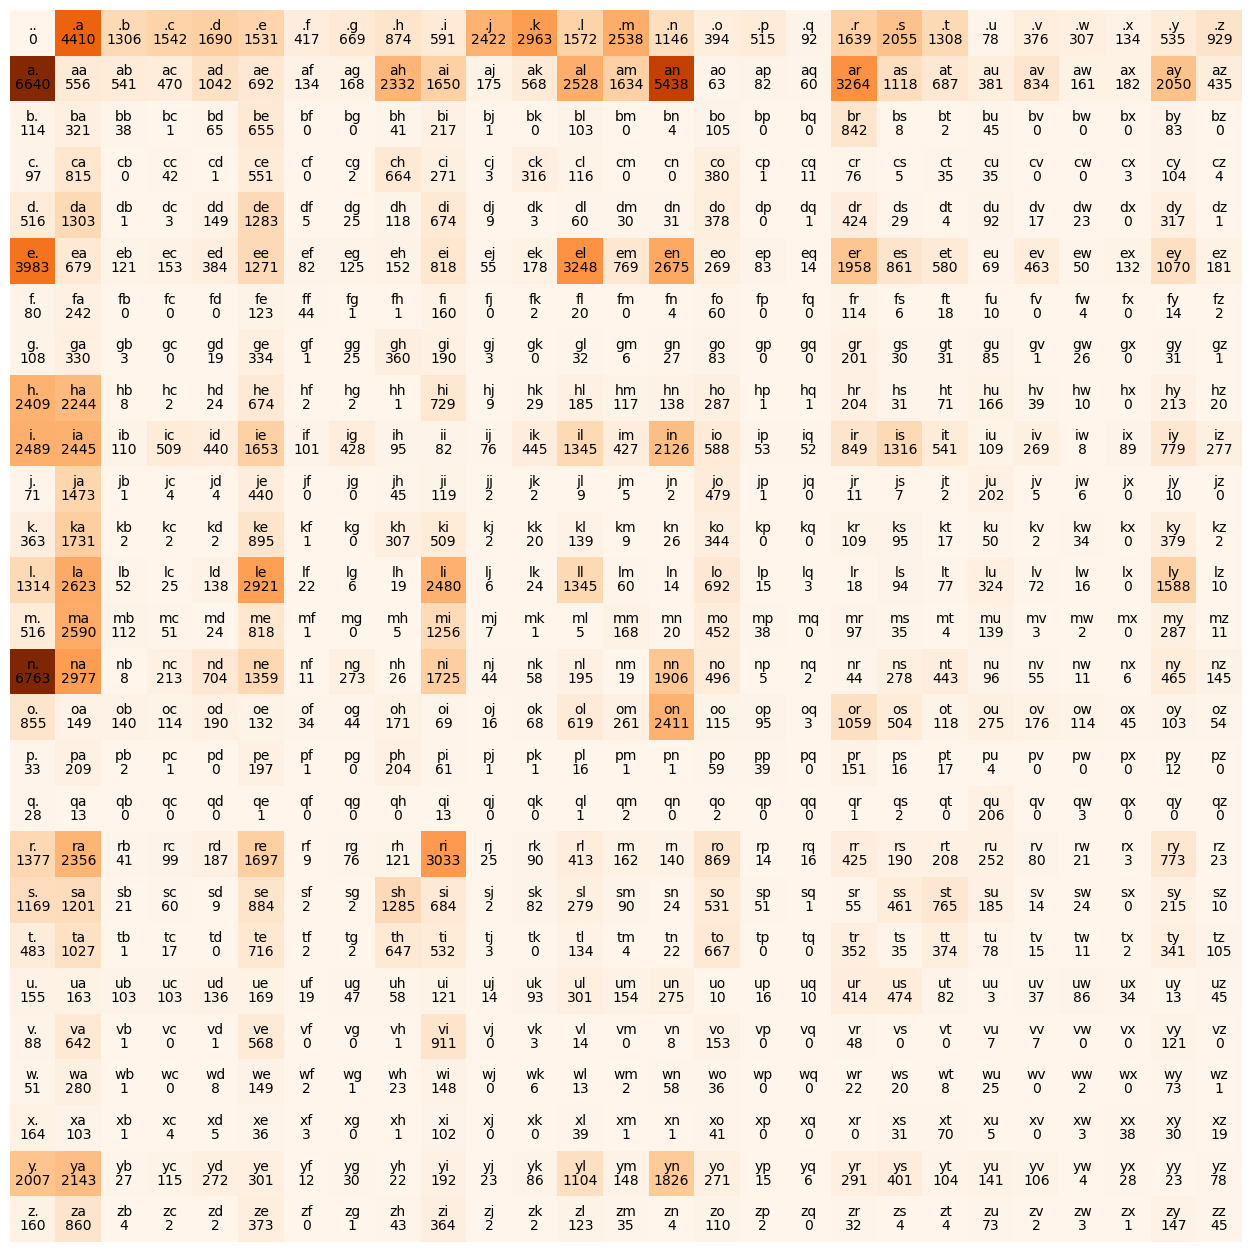

In [50]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Oranges')
for i in range(27):
    for j in range(27):
        chstr = itos[i]+itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black')
plt.axis('off');

In [93]:
P = (N+1).float() # why 1? some counts are 0 so probab will be 0 i.e. inf loglikelihood
P /= P.sum(1, keepdim=True)

In [94]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    out = []
    ix = 0
    while True:

        p = P[ix]
        # p = N[ix].float()
        # p = p/p.sum()

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))


junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.
janreli.
isa.
dyn.
rijelumemahaunayaleva.
cararr.
jen.
janarta.
maly.
abely.
a.
i.
lavadoni.
themielyawat.
f.
modam.
tavilitikiesaloeverin.
n.
e.
kalbrenelah.
anen.
ch.
k.
jan.
odridrdenanialilpergha.
tezralelia.


In [95]:
log_likelihood = 0.0
n = 0
for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = - log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


In [244]:
# Loss for complete dataset
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')
nll = - log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [246]:
# creating training set of bigrams (x, y)
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [247]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

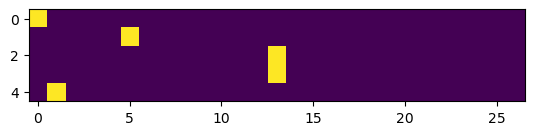

In [249]:
plt.imshow(xenc[:5, :])

In [250]:
# weight initialization
W = torch.randn((27, 27), requires_grad=True)

In [251]:
# forward pass

logits = xenc @ W # log counts
counts = logits.exp() # something that looks a lot like N i.e. counts in the above bigram graph
probs = counts / counts.sum(1, keepdims=True)

In [252]:
# loss calculation
loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()
loss

tensor(3.8451, grad_fn=<NegBackward0>)

In [253]:
# backward pass

W.grad = None # set gradients to zero
loss.backward()

In [254]:
# update step
W.data += -0.1 * W.grad

##### Summary

In [255]:
# create dataset
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()


g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)


In [260]:
for k in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()
    print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -20 * W.grad

2.464803695678711
2.4647724628448486
2.4647419452667236
2.4647111892700195
2.4646806716918945
2.4646501541137695
2.464620351791382
2.464590072631836
2.4645602703094482
2.4645304679870605
2.464501142501831
2.4644718170166016
2.464442491531372
2.4644134044647217
2.4643845558166504
2.464355707168579
2.464327096939087
2.464298963546753
2.4642703533172607
2.464242458343506
2.464214563369751
2.464186668395996
2.4641590118408203
2.4641315937042236
2.464104175567627
2.4640769958496094
2.4640495777130127
2.4640228748321533
2.463996171951294
2.4639692306518555
2.463942766189575
2.463916301727295
2.4638898372650146
2.4638640880584717
2.4638378620147705
2.4638121128082275
2.4637863636016846
2.4637606143951416
2.4637351036071777
2.463709831237793
2.4636847972869873
2.4636597633361816
2.463634490966797
2.4636099338531494
2.463585376739502
2.4635605812072754
2.463536262512207
2.4635119438171387
2.463487386703491
2.463463306427002
2.463439464569092
2.4634156227111816
2.4633920192718506
2.4633684158325

In [ ]:
# The error will never be lower than our previous N-matrix table model. Can you guess why?

In [154]:
# sampling from neural net

for i in range(5):
    out = []
    ix = 0
    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

morvann.
akela.
az.
arileri.
chaiadayra.


-- The End --